In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [3]:
data = pd.read_csv('final-data.csv')

In [4]:
data['Week Endings'] = pd.to_datetime(data['Week Endings'], errors = 'raise')
data = data.sort_values(by='Week Endings', ascending=True)

In [5]:
# Truncating data after the release of the lion king movie
lk_release = datetime.date(2019, 7, 19)
boolean_mask = data['Week Endings'].dt.date < lk_release

In [6]:
# Data after the series has been truncated
print(data[boolean_mask].tail(5).to_string())
print(data[boolean_mask].shape)

    Week Endings  Avg Ticket Price ($)  Top Ticket Price ($)  Seats Sold  Seats in Theatre   % Cap
141   2019-06-16                171.79                 225.0       13565              1696   99.98
140   2019-06-23                178.53                 225.0       13569              1696  100.01
139   2019-06-30                179.18                 225.0       13550              1696   99.87
138   2019-07-07                190.91                 225.0       13519              1696   99.64
137   2019-07-14                187.67                 225.0       12759              1696   94.04
(1129, 6)


In [7]:
data = data[boolean_mask]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1129 entries, 1265 to 137
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Week Endings          1129 non-null   datetime64[ns]
 1   Avg Ticket Price ($)  1129 non-null   float64       
 2   Top Ticket Price ($)  1129 non-null   float64       
 3   Seats Sold            1129 non-null   int64         
 4   Seats in Theatre      1129 non-null   int64         
 5   % Cap                 1129 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 61.7 KB


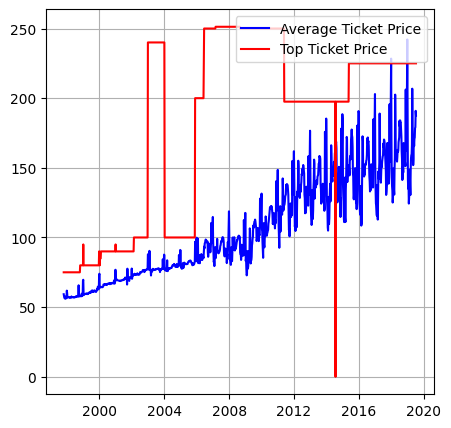

In [9]:
# Some basic plotting to check data and 
# data scale to determine whether data needs to be normalised or not
# before being used with the sequence model for prediction
# year = np.array(range(data.shape[0])) + 757
time = data['Week Endings']
plt.figure(figsize=(5, 5))
plt.grid(True)
plt.plot(time, data['Avg Ticket Price ($)'], color='b', label="Average Ticket Price")
plt.plot(time, data['Top Ticket Price ($)'], color='r', label="Top Ticket Price")
plt.legend(loc=1)
plt.show()

In [10]:
series = data['Avg Ticket Price ($)']
split_time = int(len(series) * 0.85)

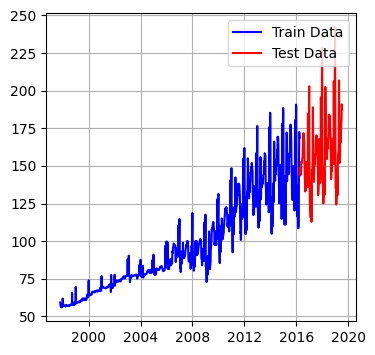

In [11]:
x_train = series[:split_time]
time_train = time[:split_time]
x_valid = series[split_time:]
time_valid = time[split_time:]

plt.figure(figsize=(4, 4))
plt.grid(True)
plt.plot(time_train, x_train, color='b', label="Train Data")
plt.plot(time_valid, x_valid, color='r', label="Test Data")
plt.legend(loc=1)
plt.show()

# Utilities:

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [13]:
# Defining parameters
window_size = 20
batch_size = 4
shuffle_buffer = 1000

In [14]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)

In [15]:
# Checking the windowed training set:
list(train_set.take(2).as_numpy_iterator())

[(array([[ 66.8 ,  66.83,  66.9 ,  66.75,  67.34,  67.35,  67.39,  67.4 ,
           67.1 ,  67.29,  67.09,  69.18,  67.2 ,  66.9 ,  67.25,  76.7 ,
           76.81,  69.24,  69.23,  70.15],
         [ 58.12,  56.75,  56.42,  56.52,  56.08,  57.56,  56.5 ,  56.29,
           56.58,  61.84,  60.21,  57.06,  56.93,  57.27,  57.22,  57.07,
           57.03,  57.18,  57.03,  57.05],
         [ 76.81,  69.24,  69.23,  70.15,  69.37,  69.46,  69.37,  69.29,
           69.21,  69.09,  69.  ,  68.93,  68.96,  68.91,  69.08,  68.7 ,
           68.77,  68.85,  68.95,  69.3 ],
         [121.93, 122.44, 121.61, 119.28, 116.66, 109.78, 110.77, 111.81,
          109.49, 117.47, 115.99, 112.81, 106.5 , 112.55, 110.22, 112.99,
          140.39, 119.17, 120.07, 123.84]]),
  array([ 69.37,  56.61,  69.27, 138.85])),
 (array([[75.03, 74.73, 75.  , 75.24, 75.4 , 75.59, 76.2 , 76.66, 75.85,
          75.77, 76.19, 76.23, 75.14, 76.63, 76.8 , 76.78, 76.56, 76.55,
          76.61, 76.84],
         [79.81, 80

In [16]:
# Creating the validation dataset
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer)

In [27]:
# Resetting any prior defined model weight data
tf.keras.backend.clear_session()

# Defining the model
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([
    l0
])

In [33]:
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=['mae'])

In [34]:
# Training Parameters
epochs = 100

In [36]:
history = model.fit(train_set, epochs=epochs, validation_data=valid_set)

Epoch 1/100


235/235 [==============================] - 1s 1ms/step - loss: 931.0298 - mae: 931.5298 - val_loss: 1455.7726 - val_mae: 1456.2726
Epoch 2/100
235/235 [==============================] - 0s 1ms/step - loss: 951.0547 - mae: 951.5547 - val_loss: 2724.2131 - val_mae: 2724.7131
Epoch 3/100
235/235 [==============================] - 0s 961us/step - loss: 937.2664 - mae: 937.7661 - val_loss: 1793.6560 - val_mae: 1794.1560
Epoch 4/100
235/235 [==============================] - 0s 940us/step - loss: 927.0300 - mae: 927.5297 - val_loss: 2199.5945 - val_mae: 2200.0945
Epoch 5/100
235/235 [==============================] - 0s 945us/step - loss: 941.8862 - mae: 942.3856 - val_loss: 702.9359 - val_mae: 703.4359
Epoch 6/100
235/235 [==============================] - 0s 944us/step - loss: 935.3924 - mae: 935.8924 - val_loss: 1492.4110 - val_mae: 1492.9110
Epoch 7/100
235/235 [==============================] - 0s 972us/step - loss: 952.1175 - mae: 952.6175 - val_loss: 1513.9617 - val_mae: 1514.4617
Epo

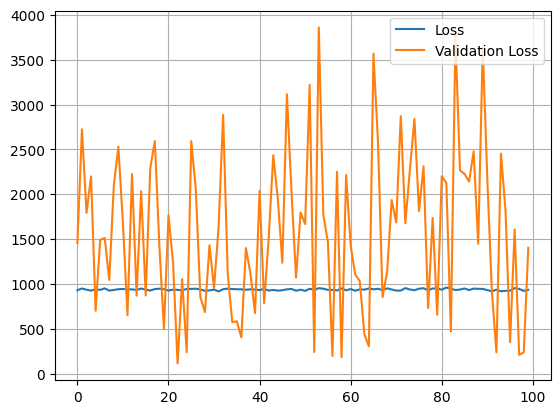

In [40]:
hist = history.history
epoch_life = range(len(loss))
loss = hist['loss']
val_loss = hist['val_loss']
mae = hist['mae']
val_mae = hist['val_mae']

plt.plot(epoch_life, loss, label="Loss")
plt.plot(epoch_life, val_loss, label="Validation Loss")

plt.legend(loc=1)
plt.grid(True)
plt.show()

In [38]:
# Checking layer weights:
print(l0.get_weights())

[array([[ 2.8783028e+00],
       [-3.3406687e+00],
       [-3.4524262e-01],
       [ 6.5935695e-01],
       [-3.6440396e+00],
       [ 1.0248307e+00],
       [-1.4219880e-03],
       [ 6.8497461e-01],
       [ 2.5426799e-01],
       [ 3.3018208e+00],
       [ 1.4246043e+00],
       [ 1.7825752e-01],
       [ 1.6442583e+00],
       [ 3.1122413e+00],
       [ 1.3901063e+00],
       [ 7.5641423e-01],
       [ 9.6835119e-01],
       [-2.9303184e+00],
       [-1.8237820e+00],
       [ 3.7593303e+00]], dtype=float32), array([-0.09590965], dtype=float32)]


In [ ]:
output = series[split_time:]

### Chores: 
To perform sanity check, normalize data, and optionally set a benchmark for the model using statistical methods